# **Class 11: Semantic Router**

Semantic Router is a superfast decision-making layer for your LLMs and agents. Rather than waiting for slow LLM generations to make tool-use decisions, we use the magic of semantic vector space to make those decisions — routing our requests using semantic meaning.

https://github.com/aurelio-labs/semantic-router

In [1]:
from IPython.display import Image, display
project_path = "C:/Users/tiago/OneDrive/Documentos/CapstoneProject/"

## How It Works:

1. Embedding Generation: Inputs and possible actions/tools are embedded into a high-dimensional vector space using a vectorizer like OpenAI embeddings, Sentence Transformers, or custom models.

2. Similarity Computation: The router computes the similarity between the input vector and the vectors for available routes.

3. Routing Decision: Based on the highest similarity score, the Semantic Router directs the request to the best match.

## Why Use a Semantic Router?

1. Speed:
The Semantic Router is faster than relying on LLM-generated responses for every decision, as it avoids invoking the model repeatedly for intermediate steps.

2. Interpretability:
By inspecting similarity scores, developers can clearly understand why a particular route was chosen, enabling more transparent decision-making.

3. Determinism:
Unlike LLMs, which can produce varying outputs for the same input, the Semantic Router provides consistent decisions, increasing reliability in many workflows.

## Practical Applicability
While it may not be suitable for every scenario, especially those requiring deep reasoning or complex inferences, it excels in use cases involving intent recognition or straightforward routing tasks, making it a transformative tool for such contexts.


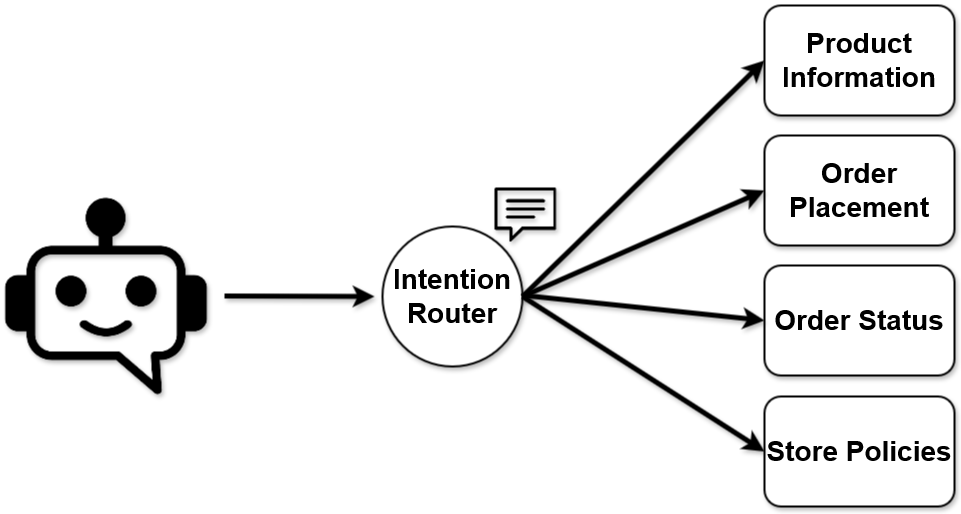

In [2]:
display(Image(filename=project_path+'images/class11/1.png', width=1000, height=800))

In [ ]:
%pip install -qU semantic-router

In [49]:
from semantic_router import Route
from semantic_router.encoders import OpenAIEncoder, HuggingFaceEncoder
from semantic_router import RouteLayer
import pandas as pd
from sklearn.model_selection import train_test_split

## Preprocessing

In [50]:
# Load the dataframes json files
df_loaded = pd.read_json("synthetic_intetions.json")

In [51]:
X = df_loaded[['Id','Message']]
y = df_loaded['Intention'].to_list()

In [52]:
# Split the dataset with stratification
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, random_state=0, stratify=y
)

In [53]:
# Replace "None" with None
y_train = [None if i == "None" else i for i in y_train]
y_test = [None if i == "None" else i for i in y_test]

In [54]:
# Set the column Id as the index
X_train.set_index('Id', inplace=True)
X_test.set_index('Id', inplace=True)

In [57]:
order_status_messages = []
create_order_messages = []
product_information_messages = []

for message, label in zip(X_train["Message"], y_train):
    if label == 'order_status':
        order_status_messages.append(message)
    elif label == 'create_order':
        create_order_messages.append(message)
    elif label == 'product_information':
        product_information_messages.append(message)

In [58]:
product_information_messages

['What is the battery life of the Nintendo Switch?',
 'Can you tell me about the sound quality of the JBL Flip 5?',
 'What is the difference between the iPad Air and iPad Pro?',
 'Are there any discounts on the Bose SoundLink?',
 'Can you provide a description of the Google Nest Hub?',
 'What is the weight of the HP Spectre x360?',
 'What are the specifications of the Samsung Galaxy S21?',
 'Is the Apple AirPods Pro compatible with Android?',
 'What are the connectivity options for the LG Gram laptop?',
 'What is the storage capacity of the Samsung Galaxy Tab?',
 'What is the refresh rate of the ASUS ROG monitor?',
 'Does the Oculus Quest 2 come with any games?',
 'How does the performance of the Razer Blade compare to others?',
 'What are the key features of the Microsoft Surface Pro 8?',
 'What colors are available for the Dell XPS 13?',
 'Does the Fitbit Charge 5 have GPS?',
 'What are the dimensions of the LG OLED TV?',
 'Is there a warranty for this product?',
 'What is the price 

## Routes

We start by defining a dictionary mapping routes to example phrases that should trigger those routes.

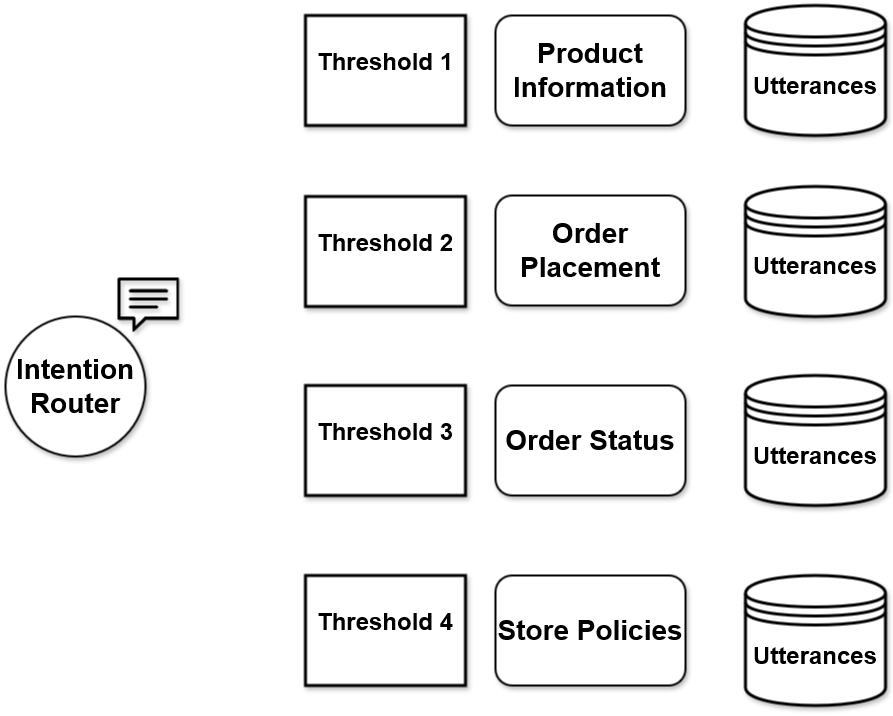

In [3]:
display(Image(filename=project_path+'images/class11/2.png', width=1000, height=800))

In [79]:
order_status_messages = []
create_order_messages = []
product_information_messages = []
support_information_messages = []

for message, label in zip(X_train["Message"], y_train):
    if label == 'order_status':
        order_status_messages.append(message)
    elif label == 'create_order':
        create_order_messages.append(message)
    elif label == 'product_information':
        product_information_messages.append(message)
    elif label == 'support_information':
        support_information_messages.append(message)

order_status = Route(
    name="order_status",
    description="The user wants to know the status of their order.",
    utterances=order_status_messages,
)

create_order = Route(
    name="create_order",
    description="The user intends to place an order for a product on the Cobuy platform.",
    utterances=create_order_messages,
)

product_information = Route(
    name="product_information",
    description="The user is interested in obtaining information about a specific product available on the Cobuy platform.",
    utterances=product_information_messages,
)

support_infromation = Route(
    name="support_information",
    description="The user is seeking information on pricing, availability, delivery, returns, customer support, and additional services like payment methods, user manuals, and warranties.",
    utterances=support_information_messages,
)

Let's create a list of routes:

In [80]:
routes = [order_status, create_order, product_information, support_infromation]

In [61]:
routes[0]

Route(name='order_status', utterances=['I want to know the current status of order #77889.', 'Where is my order #98765 right now?', 'What is the latest update on order #66778?', 'Can you check the status of my order #22334?', 'What’s the status of my order #39393?', 'Can you confirm the delivery date for order #88990?', 'Please update me on the status of order #24680.', 'Can you check if order #29292 is out for delivery?', 'Is my order #55667 still on track for delivery?', 'Can you provide an update on order #23232?', 'When will order #44556 be delivered?', 'Is there any delay with order #27272?', 'What’s the status of my order #31313?', 'I’d like to check the delivery status for order #54321.', 'Can you tell me if order #17181 has shipped?', 'What’s the delivery status of my order #19101?', 'What’s the current location of my order #25252?', 'What’s the latest on my order #35353?', 'When can I expect my order #13579 to arrive?', 'What’s the tracking status for order #15161?', 'I need a

## Semantic Router

We define a route layer using these routes and using the OpenAI encoder.

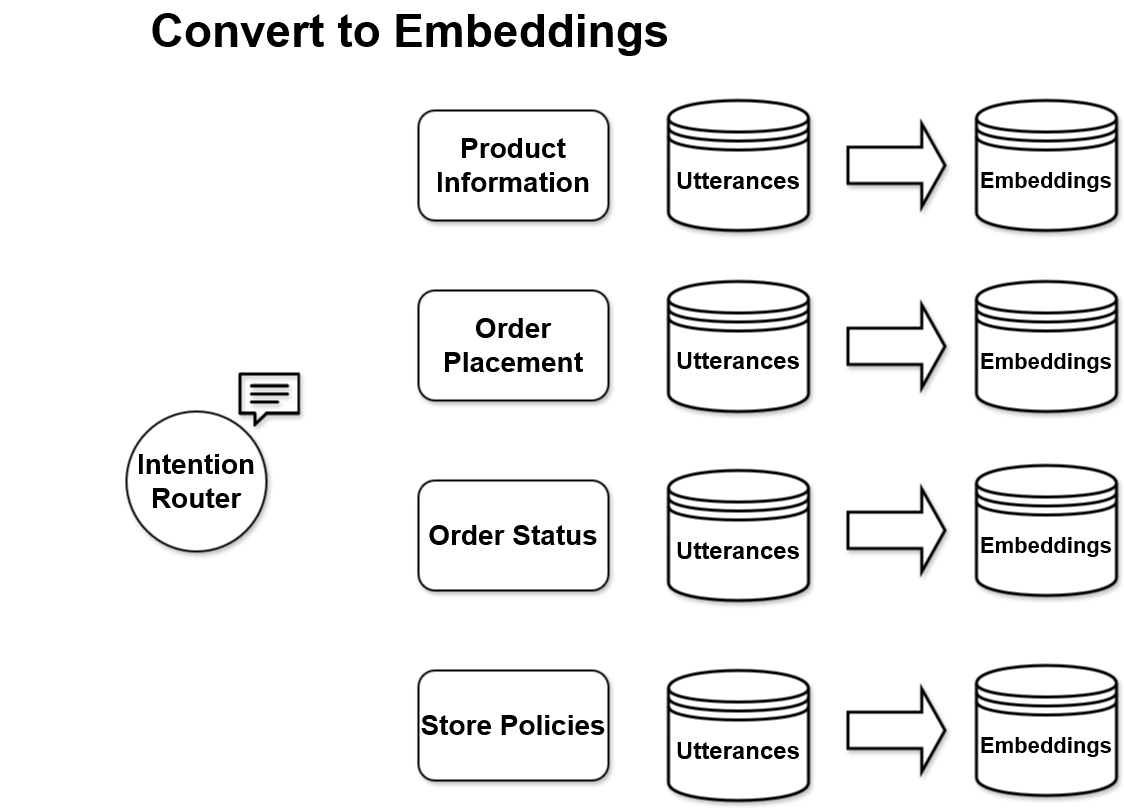

In [ ]:
display(Image(filename=project_path+'images/class11/3.png', width=1000, height=800))

In [81]:
encoder = HuggingFaceEncoder()
hf_rl = RouteLayer(encoder=encoder, routes=routes) #aggregation = "mean", "max" or "sum". #top_k = 5

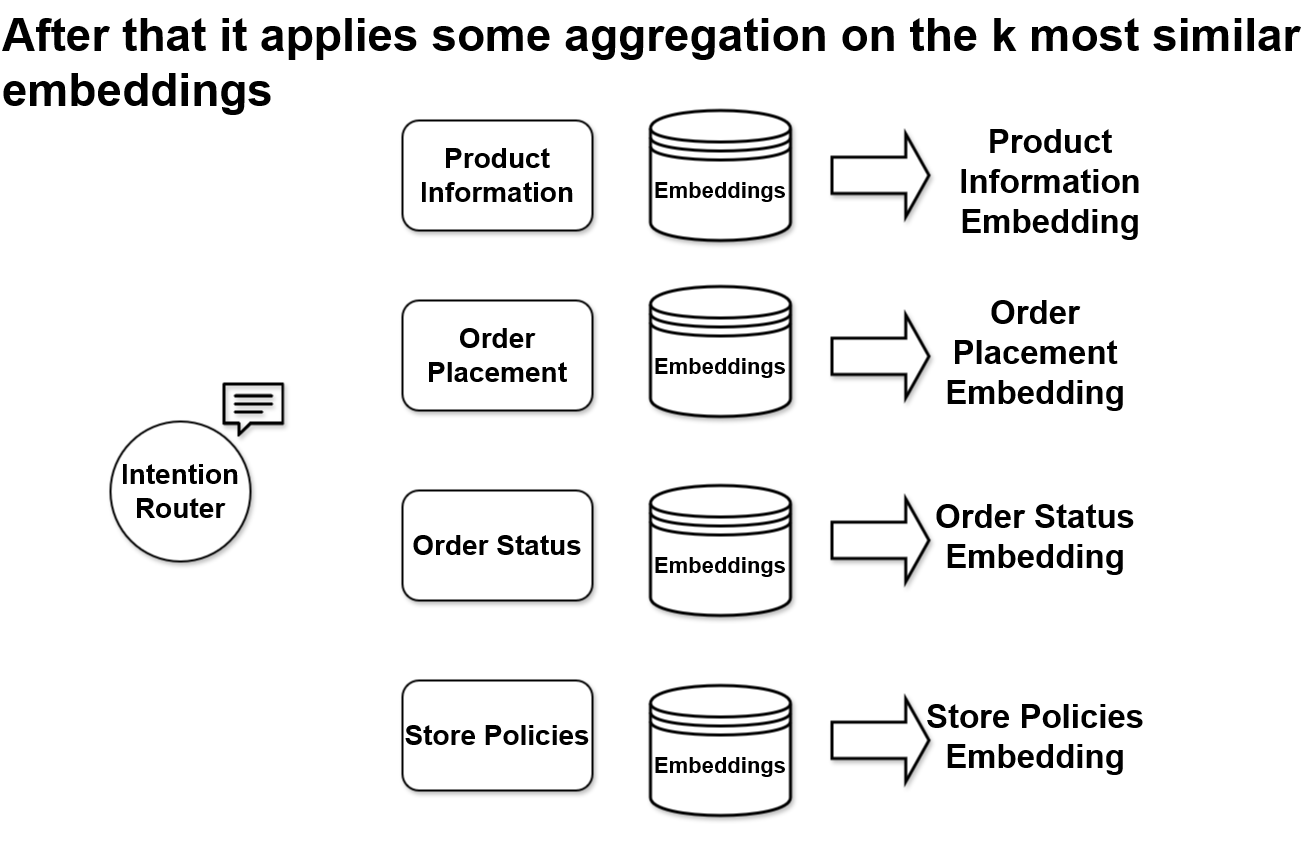

In [4]:
display(Image(filename=project_path+'images/class11/4.png', width=1000, height=800))

In [82]:
encoder = OpenAIEncoder()
oa_rl = RouteLayer(encoder=encoder, routes=routes, aggregation="mean") #aggregation = "mean", "max" or "sum" #top_k = 5

Now we can test it:

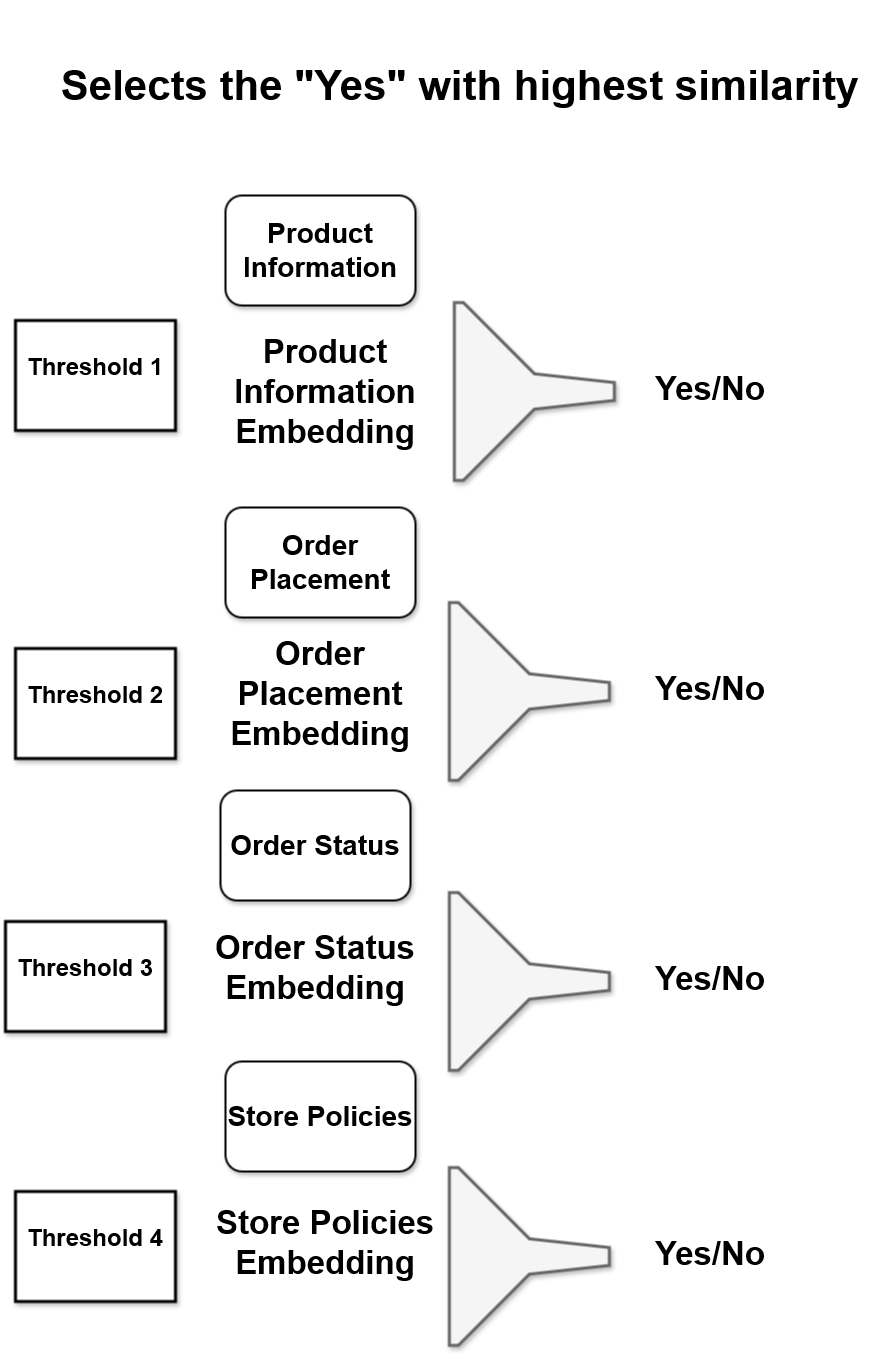

In [6]:
display(Image(filename=project_path+'images/class11/5.png', width=800, height=600))

In [64]:
hf_rl("how's the weather today?")

RouteChoice(name=None, function_call=None, similarity_score=None)

In [18]:
oa_rl("how's the weather today?")

RouteChoice(name=None, function_call=None, similarity_score=None)

In [65]:
hf_rl.retrieve_multiple_routes("Hi! Can i get my order??")

[RouteChoice(name='order_status', function_call=None, similarity_score=0.5035484168778258),
 RouteChoice(name='create_order', function_call=None, similarity_score=0.5962896263282033)]

In [66]:
oa_rl.retrieve_multiple_routes("Hi! Can i get my order??")

[RouteChoice(name='order_status', function_call=None, similarity_score=0.5939156780027575),
 RouteChoice(name='create_order', function_call=None, similarity_score=0.6270052141120199)]

We can evaluate the performance of our route layer using the evaluate method. All we need is to pass a list of utterances and target route labels:

In [83]:
# evaluate using the default thresholds
accuracy = hf_rl.evaluate(X=X_test["Message"].to_list(), y=y_test)
print(f"Accuracy: {accuracy*100:.2f}%")

Generating embeddings:   0%|          | 0/1 [00:00<?, ?it/s]

Accuracy: 71.43%


In [84]:
# evaluate using the default thresholds
accuracy = oa_rl.evaluate(X=X_test["Message"].to_list(), y=y_test)
print(f"Accuracy: {accuracy*100:.2f}%")

Generating embeddings:   0%|          | 0/1 [00:00<?, ?it/s]

Accuracy: 71.43%


On this subset we get reasonable accuracy.

## Route Layer Optimization

Our optimization works by finding the best route thresholds for each Route in our RouteLayer. We can see the current, default thresholds by calling the get_thresholds method:

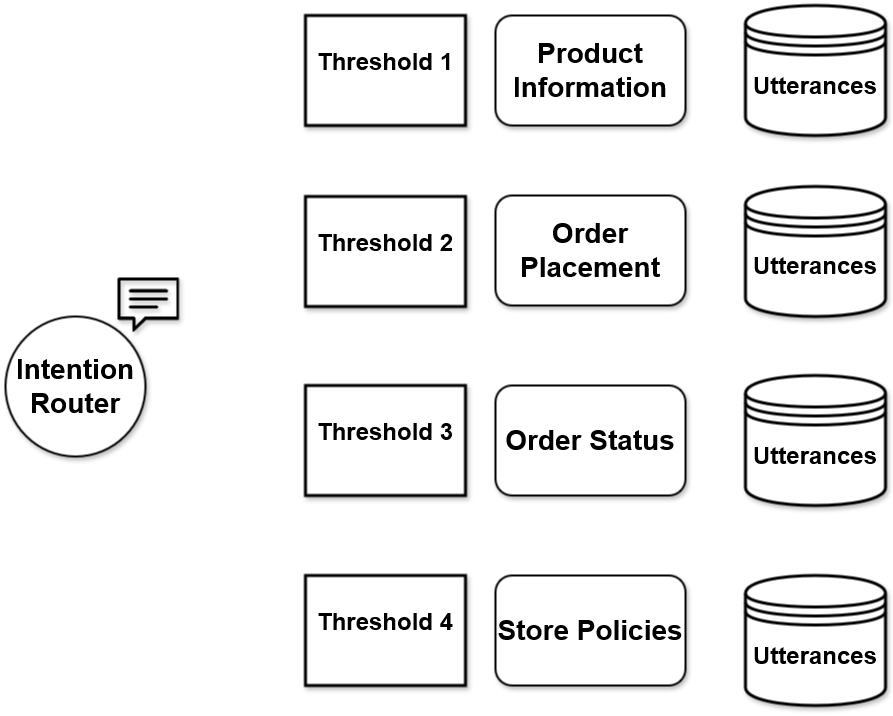

In [7]:
display(Image(filename=project_path+'images/class11/2.png', width=1000, height=800))

In [69]:
route_thresholds = hf_rl.get_thresholds()
print("Default route thresholds:", route_thresholds)

Default route thresholds: {'order_status': 0.5, 'create_order': 0.5, 'product_information': 0.5}


In [70]:
route_thresholds = oa_rl.get_thresholds()
print("Default route thresholds:", route_thresholds)

Default route thresholds: {'order_status': 0.5, 'create_order': 0.5, 'product_information': 0.5}


These are all preset route threshold values. Fortunately, it's very easy to optimize these — we simply call the fit method and provide our training utterances X, and target route labels y:

In [85]:
# Call the fit method
hf_rl.fit(X=X_train["Message"].to_list(), y=y_train, max_iter=500)

Generating embeddings:   0%|          | 0/1 [00:00<?, ?it/s]

Training:   0%|          | 0/500 [00:00<?, ?it/s]

In [86]:
# Call the fit method
oa_rl.fit(X=X_train["Message"].to_list(), y=y_train, max_iter=500)

Generating embeddings:   0%|          | 0/1 [00:00<?, ?it/s]

Training:   0%|          | 0/500 [00:00<?, ?it/s]

Let's see what our new thresholds look like:

In [87]:
route_thresholds = hf_rl.get_thresholds()
print("Updated route thresholds:", route_thresholds)

Updated route thresholds: {'order_status': 0.5, 'create_order': 0.5, 'product_information': 0.5, 'support_information': 0.5}


In [88]:
route_thresholds = oa_rl.get_thresholds()
print("Updated route thresholds:", route_thresholds)

Updated route thresholds: {'order_status': 0.5, 'create_order': 0.5, 'product_information': 0.5, 'support_information': 0.5}


These are vastly different thresholds to what we were seeing before — it's worth noting that optimal values for different encoders can vary greatly.

After training we have a final performance of:

In [89]:
accuracy = hf_rl.evaluate(X=X_test["Message"].to_list(), y=y_test)
print(f"Accuracy: {accuracy*100:.2f}%")

Generating embeddings:   0%|          | 0/1 [00:00<?, ?it/s]

Accuracy: 71.43%


In [90]:
accuracy = oa_rl.evaluate(X=X_test["Message"].to_list(), y=y_test)
print(f"Accuracy: {accuracy*100:.2f}%")

Generating embeddings:   0%|          | 0/1 [00:00<?, ?it/s]

Accuracy: 71.43%


In [91]:
oa_rl.evaluate(X=X_train["Message"].to_list(), y=y_train)

Generating embeddings:   0%|          | 0/1 [00:00<?, ?it/s]

0.9917355371900827

That is much better. If we wanted to optimize this further we can focus on adding more utterances to our existing routes, analyzing where exactly our failures are, and modifying our routes around those. This extended optimzation process is much more manual, but with it we can continue optimizing routes to get even better performance.

In [77]:
for (index, row), label in zip(X_test.iterrows(), y_test):
    message = row["Message"]
    prediction = hf_rl(message)

    if prediction.name == label:
        continue
    else:
        print(f"Id: {index}")
        print(f"Message: {message}")
        print(f"True Route: {label}, Predicted Route: {prediction.name}")
        print()

Id: 105
Message: What discounts are currently available on electronics?
True Route: support_information, Predicted Route: product_information

Id: 64
Message: Can you tell me the features of the latest iPhone?
True Route: product_information, Predicted Route: None

Id: 91
Message: Can you provide details on the charging time for the Anker Power Bank?
True Route: product_information, Predicted Route: None

Id: 122
Message: Are there any shipping restrictions I should know about?
True Route: support_information, Predicted Route: None

Id: 110
Message: Do you offer express delivery options?
True Route: support_information, Predicted Route: order_status

Id: 78
Message: What accessories come with the Canon EOS R camera?
True Route: product_information, Predicted Route: None



In [34]:
for (index, row), label in zip(X_test.iterrows(), y_test):
    message = row["Message"]
    prediction = oa_rl(message)

    if prediction.name == label:
        continue
    else:
        print(f"Id: {index}")
        print(f"Message: {message}")
        print(f"True Route: {label}, Predicted Route: {prediction.name}")
        print()

Id: 105
Message: What discounts are currently available on electronics?
True Route: support_information, Predicted Route: product_information

Id: 64
Message: Can you tell me the features of the latest iPhone?
True Route: product_information, Predicted Route: None

Id: 91
Message: Can you provide details on the charging time for the Anker Power Bank?
True Route: product_information, Predicted Route: None

Id: 122
Message: Are there any shipping restrictions I should know about?
True Route: support_information, Predicted Route: None

Id: 110
Message: Do you offer express delivery options?
True Route: support_information, Predicted Route: None

Id: 78
Message: What accessories come with the Canon EOS R camera?
True Route: product_information, Predicted Route: None



## Save the Route Layer

To save our route layer we call the to_json method:

In [32]:
hf_rl.to_json("layer.json")

2024-11-19 11:19:45 INFO semantic_router.utils.logger Saving route config to layer.json


## Load the Route Layer

It tells us our encoder type, encoder name, and routes. This is everything we need to initialize a new router. To do so, we use the from_json method.

In [ ]:
rl = RouteLayer.from_json("layer.json")

## What If It Doesn't Work?

If the Semantic Router cannot confidently determine a route (e.g., when the highest similarity score falls below a predefined threshold):

1. Fallback Mechanism:
A fallback handler is triggered to manage ambiguous or unresolvable inputs, such as by redirecting them to a default action, flagging for manual review, or delegating the decision to an LLM.

2. Handling Undefined Routes:
If no route name is identified (e.g., similarity scores are inconclusive), the system gracefully processes the failure, ensuring robust operation without disrupting the overall workflow.

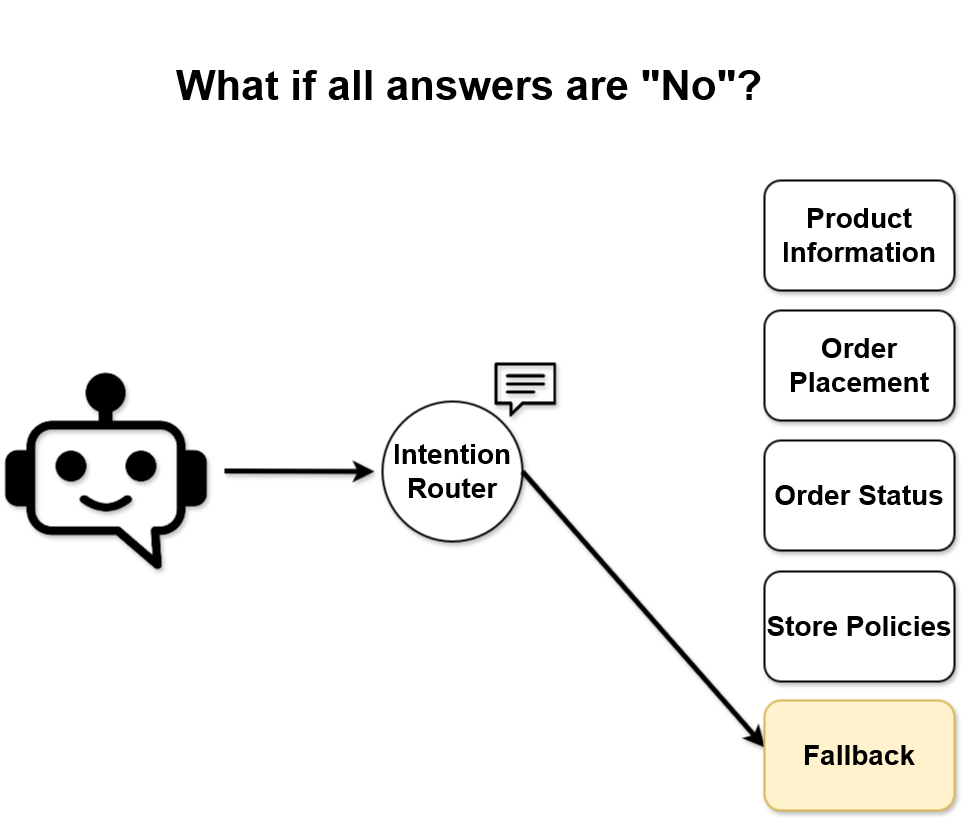

In [8]:
display(Image(filename=project_path+'images/class11/6.png', width=1000, height=800))

### The following code is just an example and does not run. If you want to run it, you try the ChatBot-Ecommerce repository.

In [ ]:
intention_classifier = rl

In [ ]:
from typing import Callable, Dict

intent_handlers: Dict[str, Callable[[Dict[str, str]], str]] = {
            "product_information": None, # Replace None with the function that handles the product_information intent
            "create_order": None, # Replace None with the function that handles the create_order intent
            "order_status": None, # Replace None with the function that handles the order_status intent
            "support_information": None, # Replace None with the function that handles the support_information intent
        }


Now imagine a user query arrives at the Semantic Router.

In [ ]:
user_input="I want to know the status of my order."

In [ ]:
# Retrieve possible routes for the user's input using the classifier
intent_routes = intention_classifier.retrieve_multiple_routes(
    user_input
)

To extract the user intention we use

In [ ]:
user_intention = intent_routes[0].name

Now we just need to route the user input to the specific route:

In [ ]:
handler = intent_handlers.get(user_intention, handle_unknown_intent)

When the Semantic Router fails to identify a suitable route, we can use a fallback mechanism to handle the situation. This involves redirecting the query to handle_unknown_intent.

In [ ]:
handler = handle_unknown_intent # Fallback handler

To actually call the handler you need to do:

In [ ]:
handler(user_input)

### Example of Unknown Intent Handler

### 1. First we define a chitchat classifier using an LLM, this classifier just outputs True or False if the input is chitchat or not.

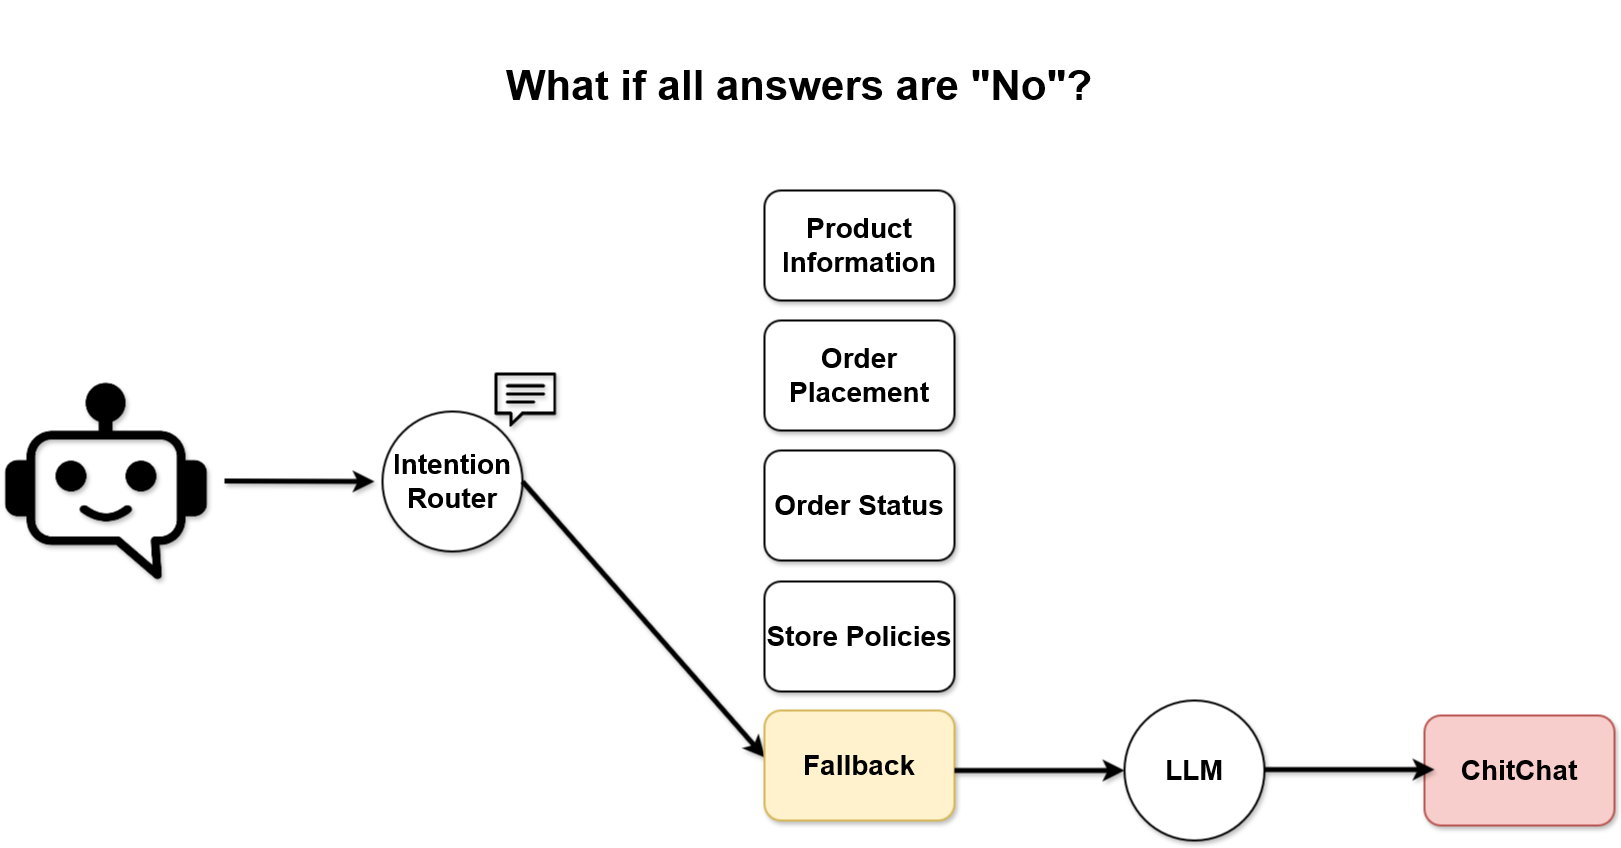

In [9]:
display(Image(filename=project_path+'images/class11/7.png', width=1000, height=800))

In [ ]:
class ChitChatClassifier(BaseModel):

    chitchat: bool = Field(
        description="""Chitchat is defined as:
        - Conversations that are informal, social, or casual in nature.
        - Topics that do not directly relate to e-commerce transactions, products, or services.
        - Examples include greetings, jokes, small talk, or personal inquiries unrelated to purchase or product details.
        If the user message falls under this category, set 'chitchat' to True.""",
    )


class ChitChatClassifierChain(Runnable):
    def __init__(self, llm, memory=False):
        super().__init__()

        self.llm = llm
        prompt_template = PromptTemplate(
            system_template=""" 
            You are specialized in distinguishing between chitchat and e-commerce-related user messages.
            Your task is to analyze each incoming user message and determine if it falls under 'chitchat'. 
            Consider the Context:
            - Analyze the user's message in the context of the entire chat history.
            - Check if previous messages in the conversation are transactional or 
            customer-service oriented that might help classify borderline cases.

            Here is the user input:
            {customer_input}

            Here is the chat history:
            {chat_history}

            Output Output your results clearly on the following format:  
            {format_instructions}
            """,
            human_template="Customer Query: {customer_input}",
        )

        self.prompt = generate_prompt_templates(prompt_template, memory=memory)

        self.output_parser = PydanticOutputParser(pydantic_object=ChitChatClassifier)
        self.format_instructions = self.output_parser.get_format_instructions()
        self.chain = (self.prompt | self.llm | self.output_parser).with_config(
            {"run_name": self.__class__.__name__}
        )  # Add a run name to the chain on LangSmith

        self.chain = self.prompt | self.llm | self.output_parser

    def invoke(self, input, config=None, **kwargs) -> ChitChatClassifier:
        result = self.chain.invoke(
            {
                "customer_input": input["customer_input"],
                "chat_history": input["chat_history"],
                "format_instructions": self.format_instructions,
            },
        )
        return result

### 2. If the user input is classified as chitcat we can then redict the user input to a chitchat chain response.

In [ ]:
class ChitChatResponseChain(Runnable):
    def __init__(self, llm, memory=True):
        super().__init__()

        self.llm = llm
        prompt_template = PromptTemplate(
            system_template=""" 
            As an AI language model engaging in friendly chitchat for Cobuy, 
            your main objectives are to maintain a conversational tone, highlight Cobuy's
            focus on electronics, and emphasize our commitment to excellent customer service. 
            Limit you answer to a maximum of 30 words.
            Here's how you should approach these interactions:

            1. **Tone and Engagement:**
            - Use a warm, friendly, and conversational tone to make users feel valued and engaged.
            - Keep the conversation light and welcoming, encouraging further interaction with Cobuy.

            2. **Personalization:**
            - Leverage previous conversation history to personalize your responses and build rapport.
            - Show genuine interest in the user's interactions by recalling past preferences or 
              inquiries related to Cobuy.

            3. **Focus on Cobuy's Core Areas:**
            - Seamlessly integrate mentions of Cobuy’s electronics expertise and superior 
              customer service into chitchat.
            - Gently steer the conversation towards topics relevant to Cobuy whenever appropriate, 
              such as by sharing interesting facts about electronics trends or highlighting new offerings.

            4. **Handling Irrelevant Questions:**
            - Politely redirect general or unrelated questions back to Cobuy's focus. 
            - For example, if asked, 'What is the capital of Portugal?', you might respond with, 
              'As an E-commerce chatbot i don't have that information, what I do know is that Cobuy offers the latest in electronic gadgets! Is there something in particular you are looking for?'

            5. **Building Rapport:**
            - Prioritize establishing a connection with the user that encourages continued 
              exploration of Cobuy’s platform.
            - Foster a sense of community and trust, making users feel appreciated within 
              the Cobuy environment.

            Your ultimate goal is to support user engagement with Cobuy using your friendly 
            demeanor and strategic conversational techniques.
            
            Here is the user input:
            {customer_input}
            """,
            human_template="Customer Query: {customer_input}",
        )

        self.prompt = generate_prompt_templates(prompt_template, memory)
        self.output_parser = StrOutputParser()

        self.chain = self.prompt | self.llm | self.output_parser

    def invoke(self, input, config=None, **kwargs):
        return self.chain.invoke(input, config=config)


### 3. The second option is if the user input is not chitchat, the input was misclassified by the semantic router and we need to redirect the user input to the correct route.

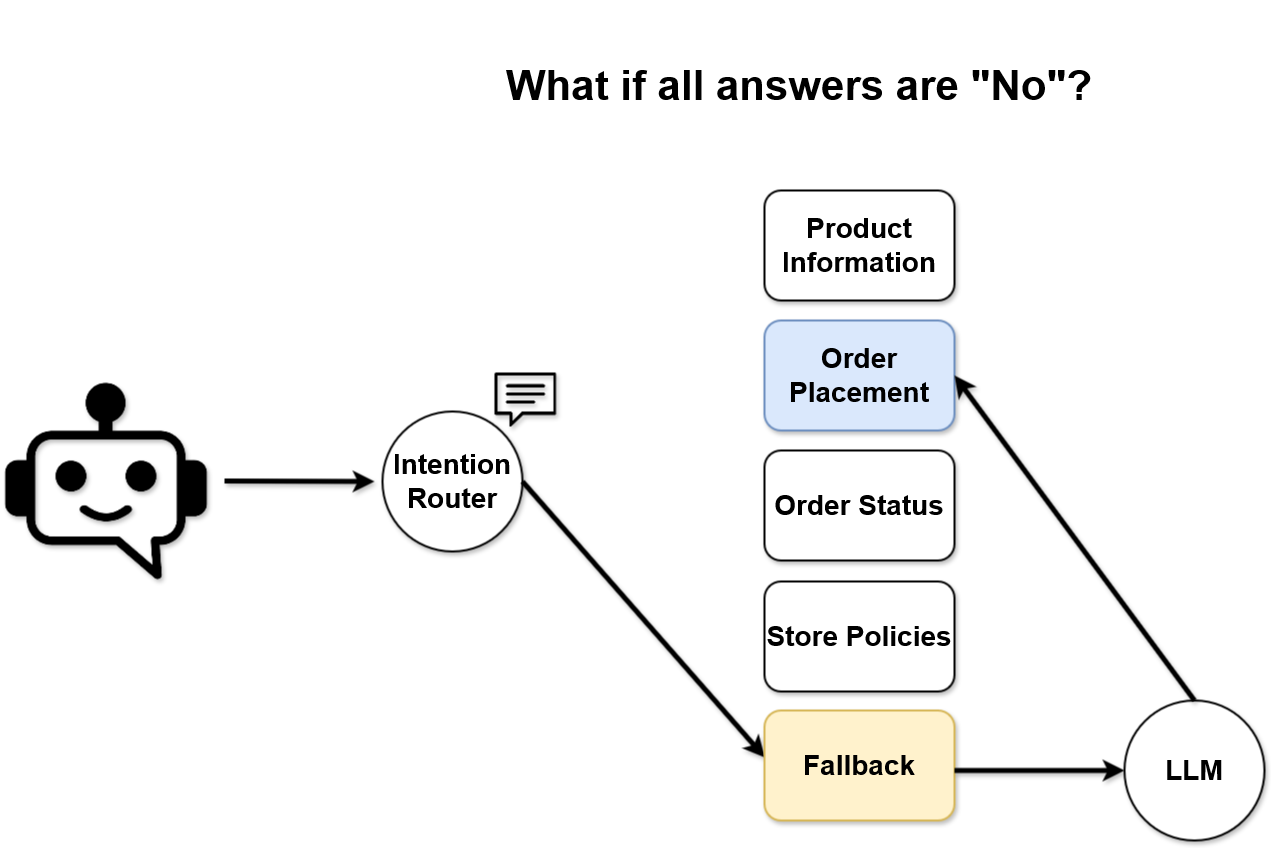

In [10]:
display(Image(filename=project_path+'images/class11/8.png', width=1000, height=800))

In [ ]:
class IntentClassification(BaseModel):

    intent: Literal[
        "product_information",
        "create_order",
        "order_status",
        "support_information",
    ] = Field(
        ...,
        description="The classified intent of the user query",
    )


class LLMRouterChain(Runnable):
    def __init__(self, llm, memory=False):
        super().__init__()

        self.llm = llm
        prompt_template = PromptTemplate(
            system_template="""
            You are an expert classifier of user intentions for the Cobuy e-commerce platform,
            which specializes in electronics. Your role is to accurately identify the user's 
            intent based on their query and the context provided by the conversation history.
            Analyze the user's query in the conversation history context and classify 
            it into one of the intents: Product Information, Create Order, Order Status, 
            or Support Information. You'll use the following detailed descriptions to classify the user's intent:

            1. **Product Information:**  
            The user is seeking details about a specific product on Cobuy. They might inquire 
            about product features, specifications, price, warranty, brand, model number, 
            or general category information. The user typically refers to the product by its 
            name or as 'it' or 'this product'.

            2. **Create Order:**  
            The user intends to place an order for a product they've already selected on Cobuy.
            They may not specify the exact quantity, and will refer to the product by its 
            name or by using terms like 'it' or 'this product'.

            3. **Order Status:**  
            The user wants to know about the status of an existing order. 
            They provide their order number and may ask about delivery date, expected delivery
            time, or the current location of the order.

            4. **Support Information:**  
            The user is interested in details about Cobuy's electronic product platform, including:
            - **Pricing:** Discounts, promotions, and transparency.
            - **Availability:** Stock status, pre-orders, restock notifications.
            - **Delivery:** Estimated times, shipping regions, restrictions.
            - **Returns:** Policies, time frames, refund processes, exchange options.
            - **Customer Support:** Contact methods, technical assistance, setup guidance.
            - **Additional Services:** Payment options, user manuals, repair services, and 
            warranties.

            **Input:**

            - Customer Input: {customer_input}  
            - Conversation History: {chat_history}

            **Output Format:**

            - Follow the specified output format and use these detailed descriptions:
            {format_instructions}
            """,
            human_template="User Query: {customer_input}",
        )

        self.prompt = generate_prompt_templates(prompt_template, memory=memory)

        self.output_parser = PydanticOutputParser(pydantic_object=IntentClassification)
        self.format_instructions = self.output_parser.get_format_instructions()
        self.chain = (self.prompt | self.llm | self.output_parser).with_config(
            {"run_name": self.__class__.__name__}
        )  # Add a run name to the chain on LangSmith

    def invoke(self, input, config=None, **kwargs):
        """Invoke the product information response chain."""
        with callbacks.collect_runs() as cb:
            return self.chain.invoke(
                {
                    "customer_input": input["customer_input"],
                    "chat_history": input["chat_history"],
                    "format_instructions": self.format_instructions,
                },
            )
